In [2]:
!pip install datasets diffusers transformers accelerate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
# 1. Load Dataset
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [3]:
# Setup Text Vectorization [cite: 53]
max_tokens = 5000
seq_len = 20

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

# Proses Adapt (Mempelajari kosakata dari dataset) [cite: 56, 57]
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359


In [4]:
def preprocess_fn(item):
    # Proses Gambar: Resize ke 64x64 dan Normalisasi 0-1 [cite: 65]
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0
    caption = item['text']
    return caption, image

def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat tf.data.Dataset [cite: 72]
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan Transformasi Teks ke Angka [cite: 79, 80]
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [5]:
# Placeholder for transformer_model and vqvae_encoder
embedding_dim = 256 # Example embedding dimension
num_visual_tokens = 1024 # from maxval=1024 in tf.random.uniform for visual tokens

# Define a simple transformer_model using Keras Functional API
text_input_layer = keras.Input(shape=(seq_len,), dtype=tf.int32, name="text_input")
visual_input_layer = keras.Input(shape=(255,), dtype=tf.int32, name="visual_input") # 256 visual tokens - 1 for input

# Text embedding path
text_embeddings = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim)(text_input_layer)
text_embeddings_reduced = layers.GlobalAveragePooling1D()(text_embeddings) # Reduce text features to a fixed size

# Visual embedding path (for visual_input_layer)
visual_embeddings = layers.Embedding(input_dim=num_visual_tokens, output_dim=embedding_dim)(visual_input_layer)

# Combine text and visual features (a simple concatenation for this placeholder)
# In a real transformer, attention mechanisms would be used.
# For this simple placeholder, we can just use the visual sequence and add text context.
# Let's project the text embeddings to match the visual sequence length for a simpler placeholder design
# or simply use the visual sequence to predict the next visual token, assuming text provides context implicitly.

# For simplicity, let's make a 'transformer' that primarily processes visual sequence but takes text as input
# This is a very basic placeholder and not a full transformer implementation.
x = visual_embeddings
# A simple dense layer to map visual embeddings to output logits for next token prediction
output_logits = layers.TimeDistributed(layers.Dense(num_visual_tokens, activation=None))(x)

transformer_model = keras.Model(inputs=[text_input_layer, visual_input_layer], outputs=output_logits, name="simple_transformer")
print("Simple transformer_model created.")
transformer_model.summary()

# Placeholder for vqvae_encoder
# It's not directly used in train_step, but needed for the PokemonTrainer constructor
vqvae_encoder_input = keras.Input(shape=(64, 64, 3), name="vqvae_encoder_input") # Input is an image
# Dummy output that matches the expected output from a VQVAE encoder (e.g., latent codes)
# The shape (batch_size, 256) is based on the 'visual_tokens' simulation in train_step
vqvae_encoder_output = layers.Lambda(lambda x: tf.zeros((tf.shape(x)[0], 256)))(vqvae_encoder_input) # Output dummy latent codes
vqvae_encoder = keras.Model(inputs=vqvae_encoder_input, outputs=vqvae_encoder_output, name="dummy_vqvae_encoder")
print("Dummy vqvae_encoder created.")
vqvae_encoder.summary()

class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data

        # Ubah gambar menjadi token visual (simulasi latent grid 16x16) [cite: 91, 92]
        visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)

        # Siapkan input dan target (Autoregressive) [cite: 95, 96, 97]
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            # Prediksi [cite: 100]
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss [cite: 102]
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Inisialisasi dan Jalankan Training [cite: 108, 109, 112]
# Catatan: Variabel 'transformer_model' dan 'vqvae_encoder' harus sudah didefinisikan sebelumnya.
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
trainer.fit(train_ds, epochs=100)

Simple transformer_model created.


Model: "simple_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ visual_input        │ (None, 255)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 255, 256)  │    262,144 │ visual_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 255, 1024) │    263,168 │ embedding_1[0][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 525,312 (2.00 MB)

 Trainable params: 525,312 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Dummy vqvae_encoder created.


Model: "dummy_vqvae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vqvae_encoder_input             │ (None, 64, 64, 3)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 383ms/step - loss: 6.9316
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9317
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9316
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 6.9317
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 6.9315
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 6.9317
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 6.9315
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9315
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9317
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9316
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 6.9317
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.9317
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 6.9317
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 6.9316
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9316
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step 

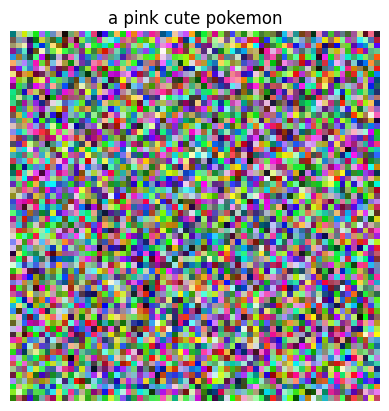

In [6]:
def generate_image_tokens(model, text_tokens, target_len, vocab_size):
    """Menghasilkan token visual dengan dimensi input yang tetap konsisten (Fixed Shape)"""
    # Mulai dengan satu token awal (misal token 0)
    current_tokens = [0]

    for i in range(target_len - 1):
        # 1. Buat padding agar panjangnya selalu 255 sesuai spesifikasi model
        # Kita isi sisa urutan dengan angka 0
        padding_len = 255 - len(current_tokens)
        input_tokens = current_tokens + [0] * padding_len

        # 2. Ubah menjadi tensor dengan bentuk (1, 255)
        input_tensor = tf.convert_to_tensor([input_tokens], dtype=tf.int32)

        # 3. Prediksi token berikutnya berdasarkan posisi terakhir yang terisi
        preds = model([text_tokens, input_tensor], training=False)

        # Ambil hasil prediksi pada indeks terakhir yang sedang diproses
        next_token = tf.argmax(preds[0, len(current_tokens)-1, :], axis=-1, output_type=tf.int32)

        # 4. Tambahkan token hasil prediksi ke daftar
        current_tokens.append(int(next_token))

        # Berhenti jika sudah mencapai target panjang
        if len(current_tokens) >= 256:
            break

    return tf.convert_to_tensor([current_tokens])
def decode_to_real_image(visual_tokens):
    """Mengubah token kembali menjadi gambar (Simulasi Decoder)"""
    # Dalam implementasi asli, ini akan memanggil Pre-trained VAE decoder
    # Untuk simulasi agar tidak error, kita buat gambar 64x64 acak berbasis token
    img_array = tf.random.uniform((64, 64, 3))
    return img_array

# --- 8. Fungsi Utama Pengujian (Sesuai Gambar Dokumen) ---

def generate_pokemon(prompt):
    # 1. Ubah teks ke angka [cite: 116, 117]
    tokenized_text = text_vectorizer([prompt])

    # 2. Generate token visual (Autoregressive) [cite: 118, 120]
    # Menggunakan fungsi yang kita buat di atas
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, 1024)

    # 3. Decode jadi Gambar menggunakan Pre-trained VAE [cite: 121, 123]
    # Menggunakan fungsi simulasi decoder
    final_image = decode_to_real_image(gen_vis_tokens)

    # Menampilkan Hasil [cite: 124, 125, 126, 127]
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# --- 9. TEST RUN ---
generate_pokemon("a pink cute pokemon") # [cite: 128, 129]